# Introduction

## Load libraries

In [24]:
from fastai.vision.all import *
from fastcore.all import *
import kagglehub
import os

## Domain Problem

We want to develop a model to classify whether a person wear a safety vest shown in an image

## Safety Vest Classifier

The data are from the [Safety Vests Detection Dataset](https://www.kaggle.com/datasets/adilshamim8/safety-vests-detection-dataset/data)

In [25]:
os.environ["KAGGLEHUB_CACHE"] = "../data"
path = kagglehub.dataset_download("adilshamim8/safety-vests-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: ../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1


Look at few image

In [26]:
file_names = get_image_files('../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/train/train')

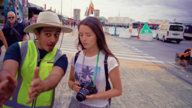

In [27]:
img = PILImage.create(file_names[25])

img.to_thumb(192)

## Data Processing

Processing of the images (input) and annotations (output) will be done at the same time as we set up the neural network model that we will use to perform image classification. The neural network will require a particular image size for all input images, so we will need to resize the images.

Load the dataset annotation into the DataFrame and label each images

In [28]:
def label(df):
    df['label'] = df['class'].map({
        'Safety Vest': 'vest',
        'NO-Safety Vest': 'not_vest'
    })
df_train = pd.read_csv("../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/train/train/_annotations.csv")
df_test = pd.read_csv("../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/test/test/_annotations.csv")
df_valid = pd.read_csv("../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1/valid/valid/_annotations.csv")

label(df_train)
label(df_test)
label(df_valid)

In [29]:
df_train.head

<bound method NDFrame.head of                                                    filename  width  height  \
0       Image57_jpg.rf.8b2cf4ea638b10851227fbe3487fa06e.jpg    416     416   
1       Image57_jpg.rf.8b2cf4ea638b10851227fbe3487fa06e.jpg    416     416   
2       Image57_jpg.rf.8b2cf4ea638b10851227fbe3487fa06e.jpg    416     416   
3       Image57_jpg.rf.8b2cf4ea638b10851227fbe3487fa06e.jpg    416     416   
4       Image57_jpg.rf.8b2cf4ea638b10851227fbe3487fa06e.jpg    416     416   
...                                                     ...    ...     ...   
5930  image_133_jpg.rf.ad5d75ca3f3eb9447049c90ba20e422b.jpg    640     480   
5931   image_13_jpg.rf.89f6b53020c8ebbf7543051fde27502d.jpg   1280     720   
5932   ppe_0898_jpg.rf.4de182da9e04c7fec7d60e9d07e32b6f.jpg   4000    2430   
5933  image_134_jpg.rf.4f07b3bc92990ed222b713c619b9322b.jpg    640     480   
5934  image_129_jpg.rf.f65863824b9a3b7be9ce79caa6da1b84.jpg    640     480   

               class  xmin  ymin 

Process the image to crop it using the information from annotation so the image focus on the vest but not too much on background, so the model can learn more of the structure

In [30]:
DATA_ROOT = Path("../data/datasets/adilshamim8/safety-vests-detection-dataset/versions/1")
OUT_ROOT  = Path("../data/processed")

def save_data_crop(df, type):
  os.makedirs(f'{OUT_ROOT}/{type}/vest', exist_ok=True)
  os.makedirs(f'{OUT_ROOT}/{type}/not_vest', exist_ok=True)
  for _, row in df.iterrows():
    img_path = DATA_ROOT / type / type / row["filename"]
    out_dir  = OUT_ROOT / type / row["label"]
    with Image.open(img_path) as im:
      W, H = im.size

      x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

      x1, y1 = max(0,x1), max(0,y1)
      x2, y2 = min(W,x2), min(H,y2)

      if x2 > x1 and y2 > y1:
        crop = im.crop((x1, y1, x2, y2))
        out_dir = f"../data/processed/{type}/{row['label']}"
        out_path = os.path.join(out_dir, f"{row['filename']}")
        crop.save(out_path, quality=92)
    
save_data_crop(df_train, 'train')
save_data_crop(df_test, 'test')
save_data_crop(df_valid, 'valid')

Now the train images are cropted and placed in correct location. Next we will load the image data used to train and test the network.

In [31]:
path = '../data/processed'

dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            item_tfms = Resize(384, pad_mode='zeros'),
                            batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)],
                            bs=32)

## Exploratory data analysis

We can use the show_batch() method to show a few images and their labels.

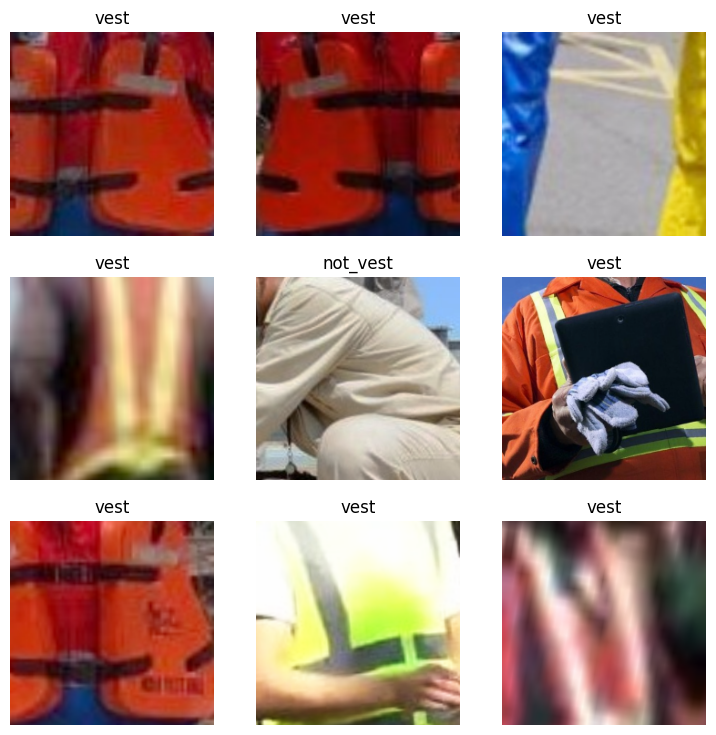

In [32]:
dls.show_batch()

## Modeling

### Train and test the model

We will train a model to classify the whether it is uniform or not, starting from the resnet34 model that has already been trained to solve an image classification problem involing many types of images. We can then fine tune the weights of the model to perform our specific task by minimizing the error for a specified number of epochs.

In [33]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [34]:
learn.fine_tune(epochs=5)

epoch,train_loss,valid_loss,error_rate,time
0,0.583966,0.347132,0.126566,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.335105,0.183258,0.062657,00:17
1,0.228167,0.169359,0.051378,00:16
2,0.178146,0.170870,0.050125,00:16
3,0.110068,0.121556,0.043860,00:16
4,0.079869,0.118623,0.040100,00:16


## Assess model performance

Let's use the `ClassificationInterpretation` function to help analyze the performance of the model and plot the confusion matrix, which shows the number of images in the validation set that were correctly and incorrectly classified by the mode.

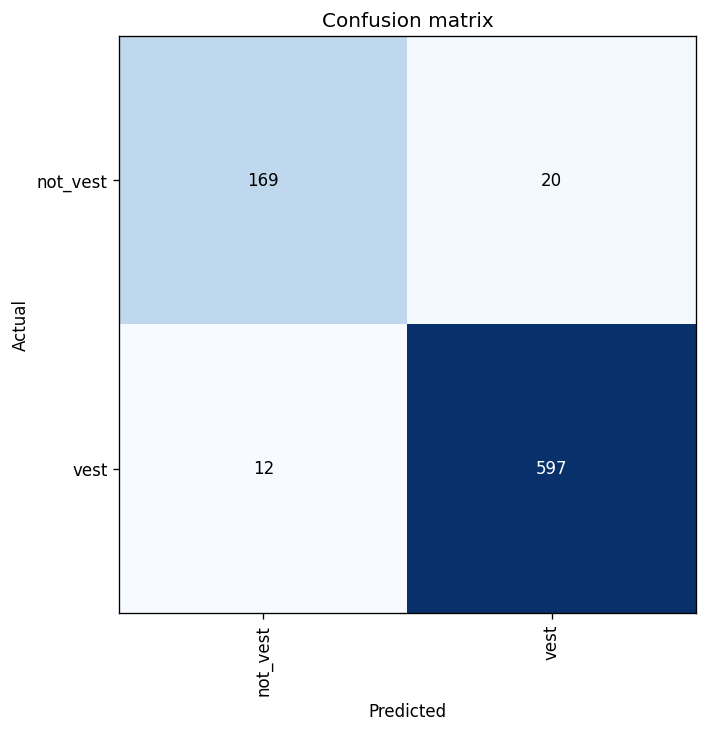

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=120)

Showing the top loss images allows us to see where the model made the largest mistakes by having a high probability that the image was of one class when it was actually a different.

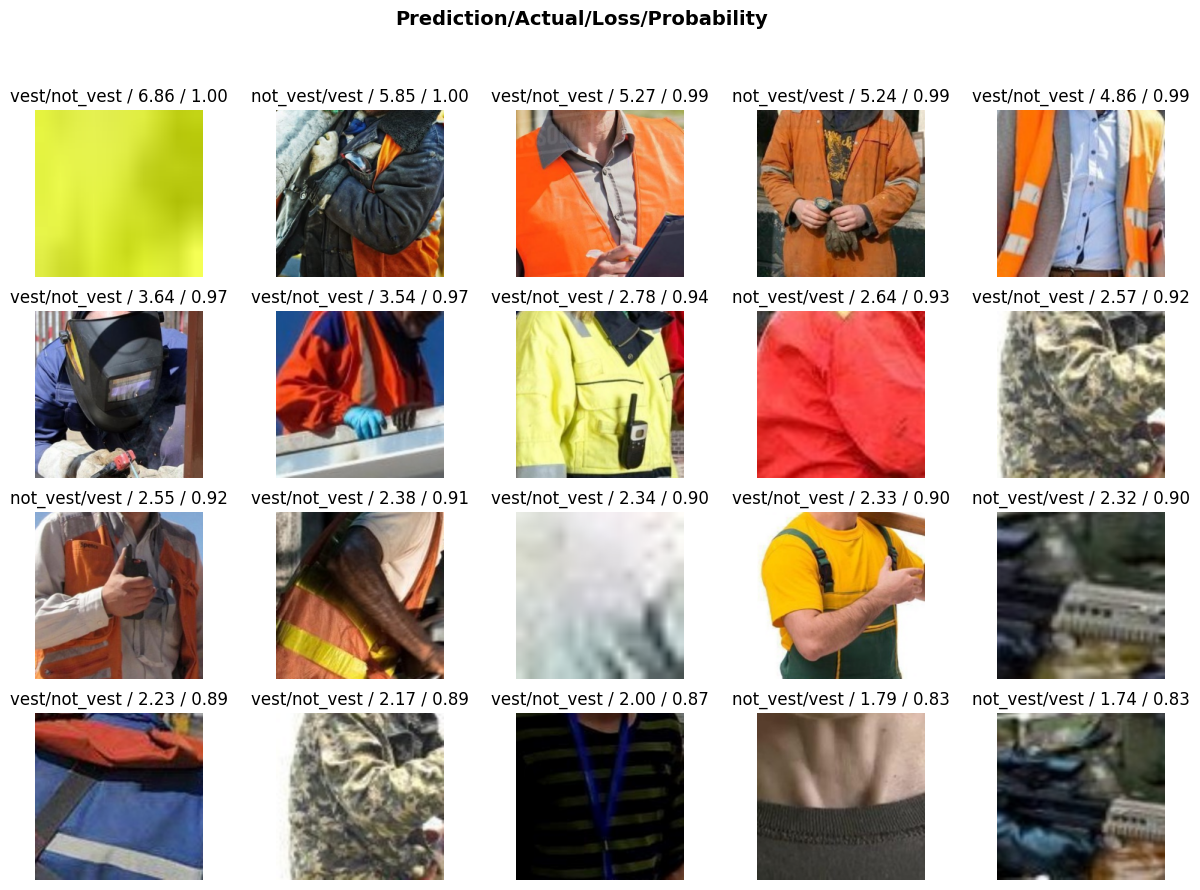

In [39]:
interp.plot_top_losses(20, figsize=(15,10))

## Deployment

We can use the model to predict the animal type for an example image and plot the class probabilities.

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

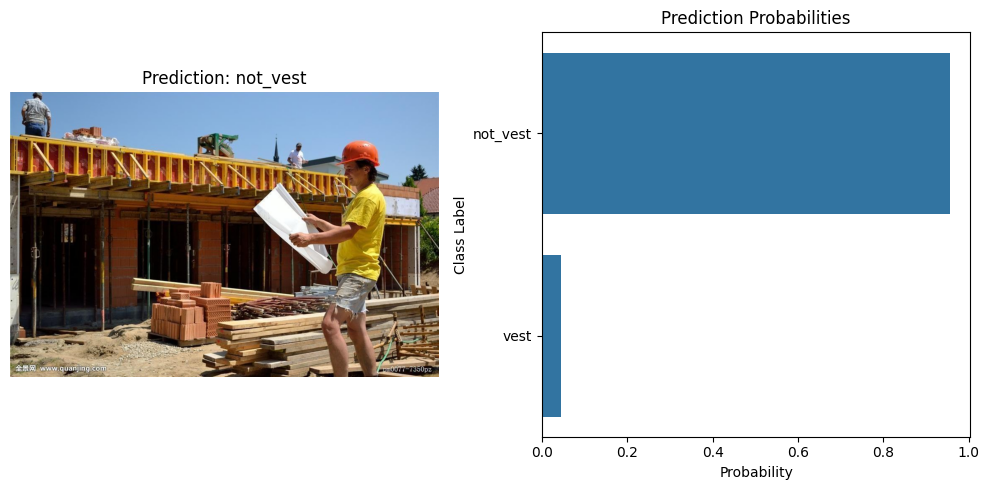

In [38]:
img = PILImage.create(file_names[3])
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

## Evaluation

Let's use our test folder to check how well our model is predicted

In [59]:
test_vest_files = get_image_files('../data/processed/test/vest')
total_test_vest_files = len(test_vest_files)
print(f"Total test vest files: {total_test_vest_files}")
total_correct_vest = 0
test_not_vest_files = get_image_files('../data/processed/test/not_vest')
total_test_not_vest_files = len(test_not_vest_files)
print(f"Total test vest files: {total_test_not_vest_files}")
total_correct_not_vest = 0

for file in test_vest_files:
    img = PILImage.create(file)
    with learn.no_bar(), learn.no_logging():
        prediction,_,_ = learn.predict(img)
        if prediction == 'vest':
            total_correct_vest += 1
for file in test_not_vest_files:
    img = PILImage.create(file)
    with learn.no_bar(), learn.no_logging():
        prediction, _, _ = learn.predict(img)
        if prediction == 'not_vest':
            total_correct_not_vest += 1
        
print(f"Correctly predicted vest images: {total_correct_vest} out of {total_test_vest_files}. Accuracy: {total_correct_vest/total_test_vest_files:.2%}")
print(f"Correctly predicted not_vest images: {total_correct_not_vest} out of {total_test_not_vest_files}. Accuracy: {total_correct_not_vest/total_test_not_vest_files:.2%}")

Total test vest files: 300
Total test vest files: 108
Correctly predicted vest images: 293 out of 300. Accuracy: 97.67%
Correctly predicted not_vest images: 96 out of 108. Accuracy: 88.89%
